# Retrieving, Processing, and Visualizing Ensemble Precipitation Forecasts from ICON

This notebook walks through the full process of accessing, processing, and visualizing raw forecast data from the ICON numerical weather model, published by MeteoSwiss as part of Switzerland’s Open Government Data (OGD) initiative.

---

##  **What You’ll Do in This Notebook**

1. ️  **Retrieve**  

    Use the OGD API to fetch ensemble forecast data (e.g., total precipitation from the ICON model).

2. 離  **Deaggregate**  

    Convert accumulated precipitation into stepwise values — for example, calculate 1-hour totals from cumulative forecasts.

3. 吝  **Regrid**  

    Transform the data from ICON’s native grid to a regular latitude/longitude grid.

4.   **Visualize**  

    Use Earthkit-Plot to display the processed data on a map, with intuitive color scales and geographic context.

---

## Retrieving Precipitation Forecast
In this first part, we retrieve precipitation forecast data from the ICON numerical weather model. To access this data, we use the `ogd_api` module from the [meteodata-lab](https://meteoswiss.github.io/meteodata-lab/) library — a convenient interface for accessing numerical weather forecasts via the [STAC (SpatioTemporal Asset Catalog) API](https://sys-data.int.bgdi.ch/api/stac/static/spec/v1/apitransactional.html#tag/Data/operation/getAsset), which provides structured access to Switzerland’s open geospatial data.

#### :folder emoticone: Browsing the STAC Catalog (Optional)

If you'd like to explore the ICON forecast datasets interactively before writing code, you can browse them directly in the STAC catalog:

&nbsp;&nbsp;&nbsp;&nbsp;:clip-emoticon: [ICON-CH1 collection](https://sys-data.int.bgdi.ch/browser/#/collections/ch.meteoschweiz.ogd-forecasting-icon-ch1?.language=en)  

&nbsp;&nbsp;&nbsp;&nbsp;:clip-emoticon: [ICON-CH2 collection](https://sys-data.int.bgdi.ch/browser/#/collections/ch.meteoschweiz.ogd-forecasting-icon-ch2?.language=en)


Below is a screenshot of the ICON-CH2 collection as seen in the STAC browser interface.


In [1]:
from pathlib import Path
import os

os.environ["ECCODES_DIR"] = str(Path.home()) + "/micromamba/envs/eccodes_env"

### Creating Requests
To retrieve the forecast data, we first define a set of API requests using the `ogd_api.Request` class.
Each request targets a different **lead time**, representing the forecasted time interval after the reference datetime.
In this example, we retrieve hourly precipitation accumulations (`TOT_PREC`) over three lead times. Each forecast value is aggregated from the reference time up to the corresponding hour.

>❗**Forecast Availability**: Forecast data will typically be available a couple of hours after the reference time — due to the model runtime and subsequent upload time. The data remains accessible for 24 hours after upload.

In [9]:
from meteodatalab import ogd_api

amount_of_lead_times = 3
reqlist = []

for i in range(amount_of_lead_times):
    req = ogd_api.Request(
        collection="ogd-forecasting-icon-ch2",
        variable="TOT_PREC",
        reference_datetime="2025-03-24T00:00:00Z",
        perturbed=True,
        horizon=f"P0DT{i}H", # ISO 8601 duration (e.g., P0DT1H = +1 hour)
    )
    reqlist.append(req)

Each parameter in the request serves the following purpose:

- `collection`: The forecast collection to use (e.g., `ogd-forecasting-icon-ch2`).
- `variable`: Meteorological variable of interest (`TOT_PREC` = total precipitation).
- `reference_datetime`: The initialization time of the forecast **in UTC** (e.g., `2025-03-20T00:00Z`).
- `perturbed`: If `True`, retrieves ensemble forecast members; if `False`, returns deterministic forecast.
- `horizon`: Forecast lead time in ISO 8601 format (e.g., `P0DT1H` = 1 hour after reference time).

### Retrieving Data
We now send our list of requests to the API and retrieve the resulting datasets using the `get_from_ogd()` function.
Each response is returned as an **xarray.DataArray**, which is efficient for handling multi-dimensional data.
> ℹ️ *Note: Earthkit recommends enabling caching to improve performance.*
> *When the cache policy is set to `"temporary"`, files are stored in a session-specific temporary directory managed by `tempfile.TemporaryDirectory`, which is automatically cleaned up at the end of the session.*
>
> *You can enable it with:*
>
> `config.set("cache-policy", "temporary")`  
> `print(config.get("cache-policy"))`
>
> *For more details, see the [Earthkit caching docs](https://earthkit-data.readthedocs.io/en/latest/examples/cache.html).*

In [10]:
ds_list = []

for req in reqlist:
    ds = ogd_api.get_from_ogd(req)
    ds_list.append(ds)

Earthkit-data caching is recommended. See: https://earthkit-data.readthedocs.io/en/latest/examples/cache.html
Earthkit-data caching is recommended. See: https://earthkit-data.readthedocs.io/en/latest/examples/cache.html                                                                   
Earthkit-data caching is recommended. See: https://earthkit-data.readthedocs.io/en/latest/examples/cache.html                                                               


## Data Preprocessing

Once the data has been loaded, continue with the preprocessing of the data.

### Merging Lead Times
To work with a continuous time series, we concatenate forecast data across different lead times into a single `xarray.DataArray`.

In [11]:
import xarray as xr
tot_prec_ds = xr.concat(ds_list, dim="lead_time")
tot_prec_ds

<xarray.DataArray (eps: 20, ref_time: 1, lead_time: 3, cell: 283876)> Size: 68MB
array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       ...,


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]], dtype=float32)
Coordinates:
  * eps         (eps) int64 160B 1 2 3 4 5 6 7 8 9 ... 13 14 15 16 17 18 19 20
  * ref_time    (ref_time) datetime64[ns] 8B 2025-03-24
  * lead_time   (lead_time) timedelta64[ns] 24B 00:00:00 01:00:00 02:00:00
    lon         (cell) float32 1MB -0.1544 -0.1637 -0.1915 ... 12.82 12.83 12.81
    lat         (cell) float32 1MB 46.97 46.98 46.98 47.13 ... 50.08 50.06 50.05
    valid_time  (ref_time, lead_time) datetime64[ns] 24B 2025-03-24 ... 2025-...
Dimensions without coordinates: cell
Attributes:
    metadata:     <earthkit.data.readers.grib.metadata.StandAloneGribMetadata...
    parameter:    {'centre': 'lssw', 'paramId': 500041, 'shortName': 'TOT_PRE...
    geography:    {'gridType': 'unstructured_grid', 'bitmapPresent': 0}
    vref:         geo
    vcoord_type:  surface
    origin_z:     0.0

The resulting `xarray.DataArray` has the following dimensions:

- `eps` (ensemble members): 20 members
- `ref_time`: Single reference time (e.g. 2025-03-21)
- `lead_time`: 3 hourly intervals
- `cell`: 283,876 spatial grid points

It includes attributes such as:
- `parameter`: Total Precipitation
- `vcoord_type`: Surface

### Disaggregating Precipitation
Convert accumulated precipitation into one-hour intervals by differencing consecutive lead times. This is done using the `delta()` function from [meteodatalab](https://meteoswiss.github.io/meteodata-lab/), which simplifies the operation.

In [12]:
from meteodatalab.operators import time_operators as time_ops
import numpy as np

prec_eps_1h = time_ops.delta(tot_prec_ds, np.timedelta64(1,"h"))


### Ensemble Aggregation
To reduce noise and highlight the central tendency of the forecast, one common approach is to compute the median across ensemble members. This can be done in a single line using xarray’s `.median()` operator. Below, we demonstrate this applied to the 1-hour precipitation differences at a selected lead time.

In [13]:
prec_avg = prec_eps_1h.isel(lead_time=2).median(dim="eps").clip(min=0)
prec_avg.attrs = prec_eps_1h.attrs


### Regridding to a Regular Grid
To enable visualization or comparison with other geospatial datasets, you may want to regrid the unstructured data onto a regular (lat/lon) grid. This can be done using the `regrid` utilities provided by [meteodata-lab](https://meteoswiss.github.io/meteodata-lab/).

Below, we define the target grid using a bounding box over the area of interest, specify the output resolution, and apply the remapping:


In [14]:
from rasterio.crs import CRS
from meteodatalab.operators import regrid

# Define the target grid extent and resolution
xmin, xmax = -0.817, 18.183   # Longitude bounds
ymin, ymax = 41.183, 51.183   # Latitude bounds
nx, ny = 950, 500             # Number of grid points in x and y

# Create a regular lat/lon grid using EPSG:4326
destination = regrid.RegularGrid(
    CRS.from_string("epsg:4326"), nx, ny, xmin, xmax, ymin, ymax
)

# Remap ICON native grid data to the regular grid
prec_avg_geo = regrid.iconremap(prec_avg, destination)

## Visualizing Precipitation on a Map
We now visualize the 1-hour ensemble median precipitation on a map. This uses [earthkit-plots](https://earthkit-plots.readthedocs.io/en/latest/examples/guide/01-introduction.html), the visualization component of [Earthkit](https://earthkit.readthedocs.io/en/latest/)—a suite of tools designed to simplify access, processing, and visualization of weather and climate data in Python.

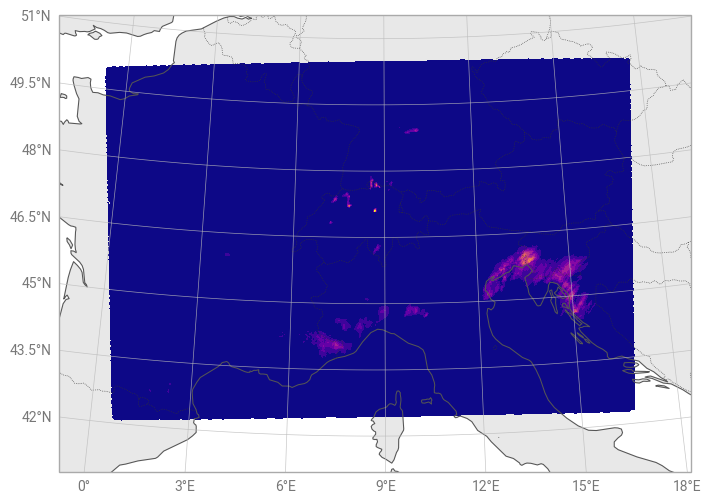

In [15]:
from earthkit.plots.geo import domains
import earthkit

# Define map domain from the bounding box used in regridding
icon_ch2_domain = domains.Domain.from_bbox(
    bbox=[xmin, xmax, ymin, ymax],
    name="CH2"
)

# Create a map instance for the defined domain
chart = earthkit.plots.Map(domain=icon_ch2_domain)

# Plot the regridded precipitation data
chart.block(prec_avg_geo, x="lon", y="lat")

# Add helpful map features
chart.land()
chart.coastlines()
chart.borders()
chart.gridlines()

# Display the map
chart.show()
